In [1]:
#Importing Packages
import numpy as np
import xarray as xr
from tqdm import tqdm
from scipy.stats import multivariate_normal
from tinygp import kernels, GaussianProcess
import jax
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import arviz as az
from src.model_fitting_functions import run_inference
from src.examples_functions import tinygp_model,tinygp_2process_model,truth_posterior_predictive,bias_posterior_predictive,posterior_predictive_realisations,singleprocess_posterior_predictive_realisations

plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.4

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
jax.config.update("jax_enable_x64", True)

In [2]:
#Creating Underlying Process Data 

X = jnp.arange(0,120,0.1)

#Truth
GP = GaussianProcess(1 * kernels.ExpSquared(1),X,diag=1e-5,mean=1.0)
Y = GP.sample(rng_key)

#Bias
GP2 = GaussianProcess(1 * kernels.ExpSquared(5),X,diag=1e-5,mean=-1.0)
Y2 = GP2.sample(rng_key)

In [3]:
# Creating sudo 'Observation' and 'Climate Model' examples and transforming to jax arrays

mask = np.ones(len(X),dtype='bool')
mask[slice(int(len(X)/3),int(len(X)*2/3))]=False

ox = X[mask][::20]
odata = Y[mask][::20]

cx = X[::10] 
cdata = (Y+Y2)[::10] 

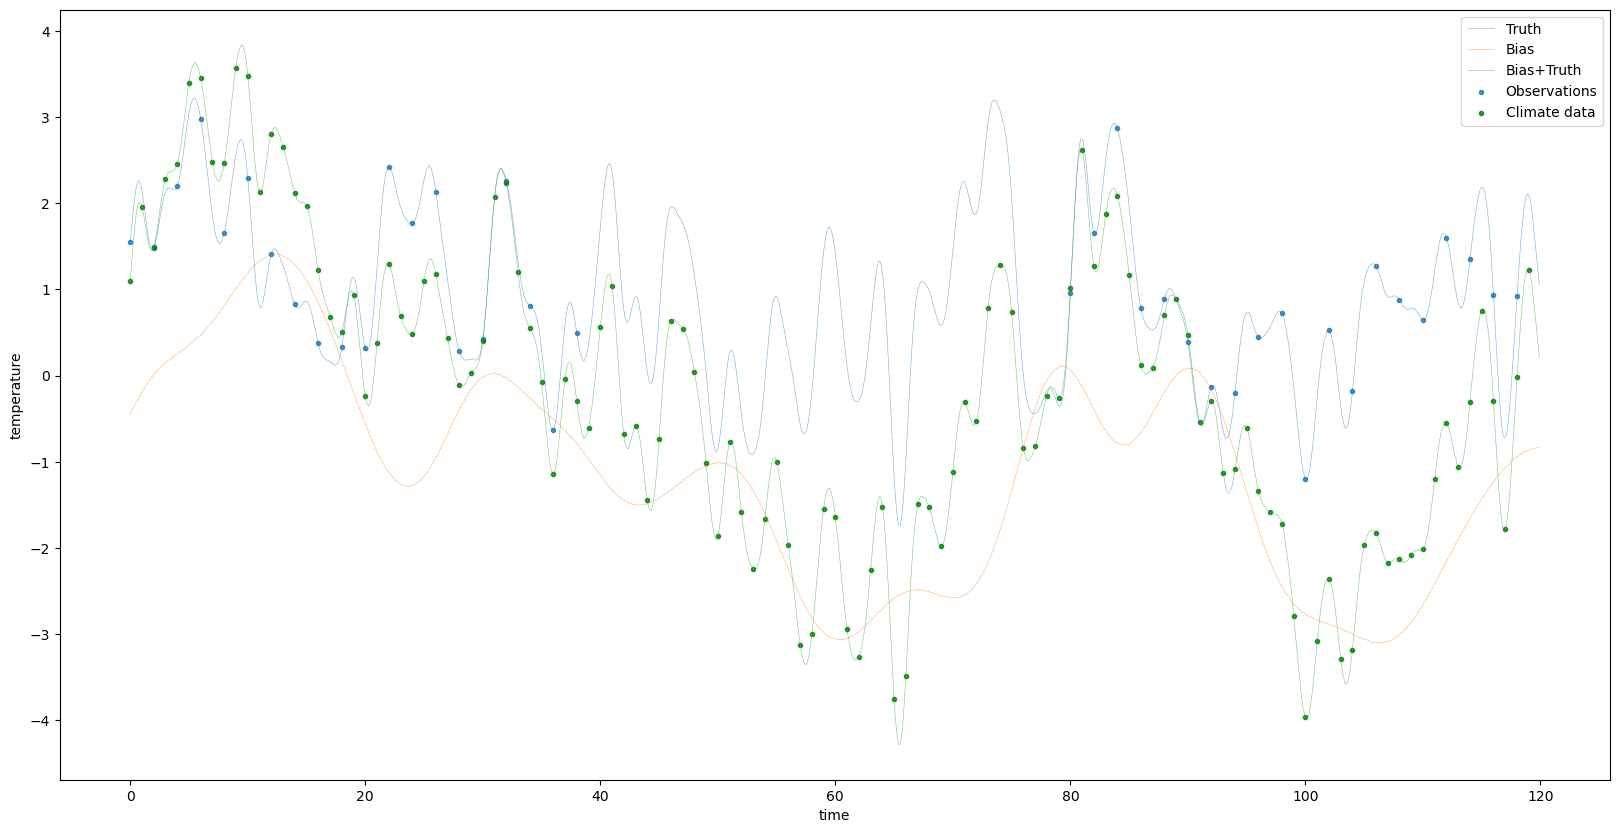

In [4]:
#Plotting data
plt.figure(figsize=(20,10))

plt.plot(X,Y,label='Truth',alpha=0.6)
plt.plot(X,Y2,label='Bias',alpha=0.6)
plt.plot(X,Y+Y2,label='Bias+Truth',alpha=0.6)

plt.scatter(ox,odata,label='Observations',alpha=0.8)
plt.scatter(cx,cdata,color='g',label='Climate data',alpha=0.8)

plt.xlabel('time')
plt.ylabel('temperature')
plt.legend()

In [5]:
# mcmc_2process = run_inference(tinygp_2process_model, rng_key_, 1000, 2000, cx,ox=ox,cdata=cdata,odata=odata)

In [6]:
# mcmc_obs = run_inference(tinygp_model, rng_key_, 1000, 2000, ox,data=odata)
# mcmc_climate = run_inference(tinygp_model, rng_key_, 1000, 2000, cx,data=cdata)

In [7]:
# #Saving Output from MCMC
# outfile_dir = '/home/jez/Bias_Correction/data/Examples_Output/'

# idata_2process = az.from_numpyro(mcmc_2process)
# idata_obs = az.from_numpyro(mcmc_obs)
# idata_climate = az.from_numpyro(mcmc_climate)

# idata_2process.to_netcdf(f'{outfile_dir}idata_2process.nc')
# idata_obs.to_netcdf(f'{outfile_dir}idata_obs.nc')
# idata_climate.to_netcdf(f'{outfile_dir}idata_climate.nc')

In [8]:
#Loading Output from MCMC
outfile_dir = '/home/jez/Bias_Correction/data/Examples_Output/'

idata_2process = az.from_netcdf(f'{outfile_dir}idata_2process.nc')
idata_obs = az.from_netcdf(f'{outfile_dir}idata_obs.nc')
idata_climate = az.from_netcdf(f'{outfile_dir}idata_climate.nc')

/home/jez/anaconda3/envs/BC/lib/python3.9/site-packages/pyproj/__init__.py:90: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [10]:
nx = X[::5] # locations where predictions will be made

In [11]:
#Realisations

num_parameter_realisations = 20
num_posterior_pred_realisations = 20

truth_realisations = posterior_predictive_realisations(truth_posterior_predictive,nx,ox,cx,odata,cdata,idata_2process,num_parameter_realisations,num_posterior_pred_realisations)
truth_realisations = truth_realisations.reshape(-1,truth_realisations.shape[-1])

bias_realisations = posterior_predictive_realisations(bias_posterior_predictive,nx,ox,cx,odata,cdata,idata_2process,num_parameter_realisations,num_posterior_pred_realisations)
bias_realisations = bias_realisations.reshape(-1,bias_realisations.shape[-1])

100%|██████████| 20/20 [00:53<00:00,  2.65s/it]


In [12]:
# Single process realisations
sp_truth_realisations = singleprocess_posterior_predictive_realisations(nx,ox,idata_obs,num_parameter_realisations,num_posterior_pred_realisations)
sp_truth_realisations = sp_truth_realisations.reshape(-1,sp_truth_realisations.shape[-1])
sp_climate_realisations = singleprocess_posterior_predictive_realisations(nx,cx,idata_climate,num_parameter_realisations,num_posterior_pred_realisations)
sp_climate_realisations = sp_climate_realisations.reshape(-1,sp_climate_realisations.shape[-1])

100%|██████████| 20/20 [00:09<00:00,  2.15it/s]


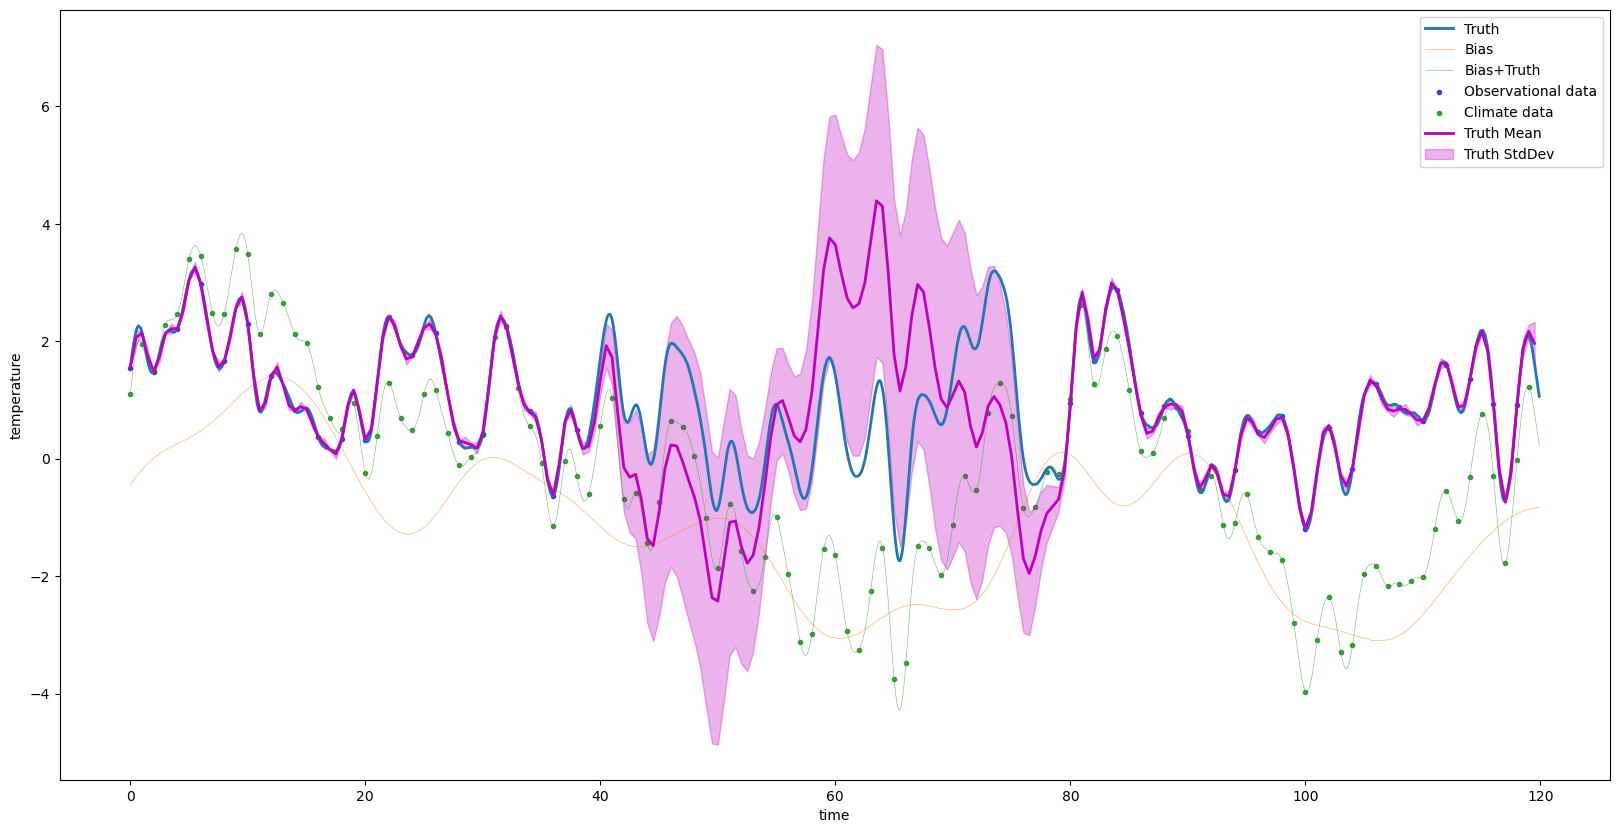

In [13]:
#Plotting Posterior Predictive for Truth
plt.figure(figsize=(20,10))

plt.plot(X,Y,label='Truth',alpha=1.0,linewidth=2)
plt.plot(X,Y2,label='Bias',alpha=0.7)
plt.plot(X,Y+Y2,label='Bias+Truth',alpha=0.7)

plt.scatter(ox,odata,color='b',label='Observational data',alpha=0.7)
plt.scatter(cx,cdata,color='g',label='Climate data',alpha=0.7)

truth_pred_mean = truth_realisations.mean(axis=0)
truth_pred_std = truth_realisations.std(axis=0)
plt.plot(nx,truth_pred_mean,label='Truth Mean',color='m',alpha=1.0,linewidth=2)
plt.fill_between(nx,truth_pred_mean+truth_pred_std,truth_pred_mean-truth_pred_std,label='Truth StdDev',color='m',alpha=0.3)

plt.xlabel('time')
plt.ylabel('temperature')
plt.legend()

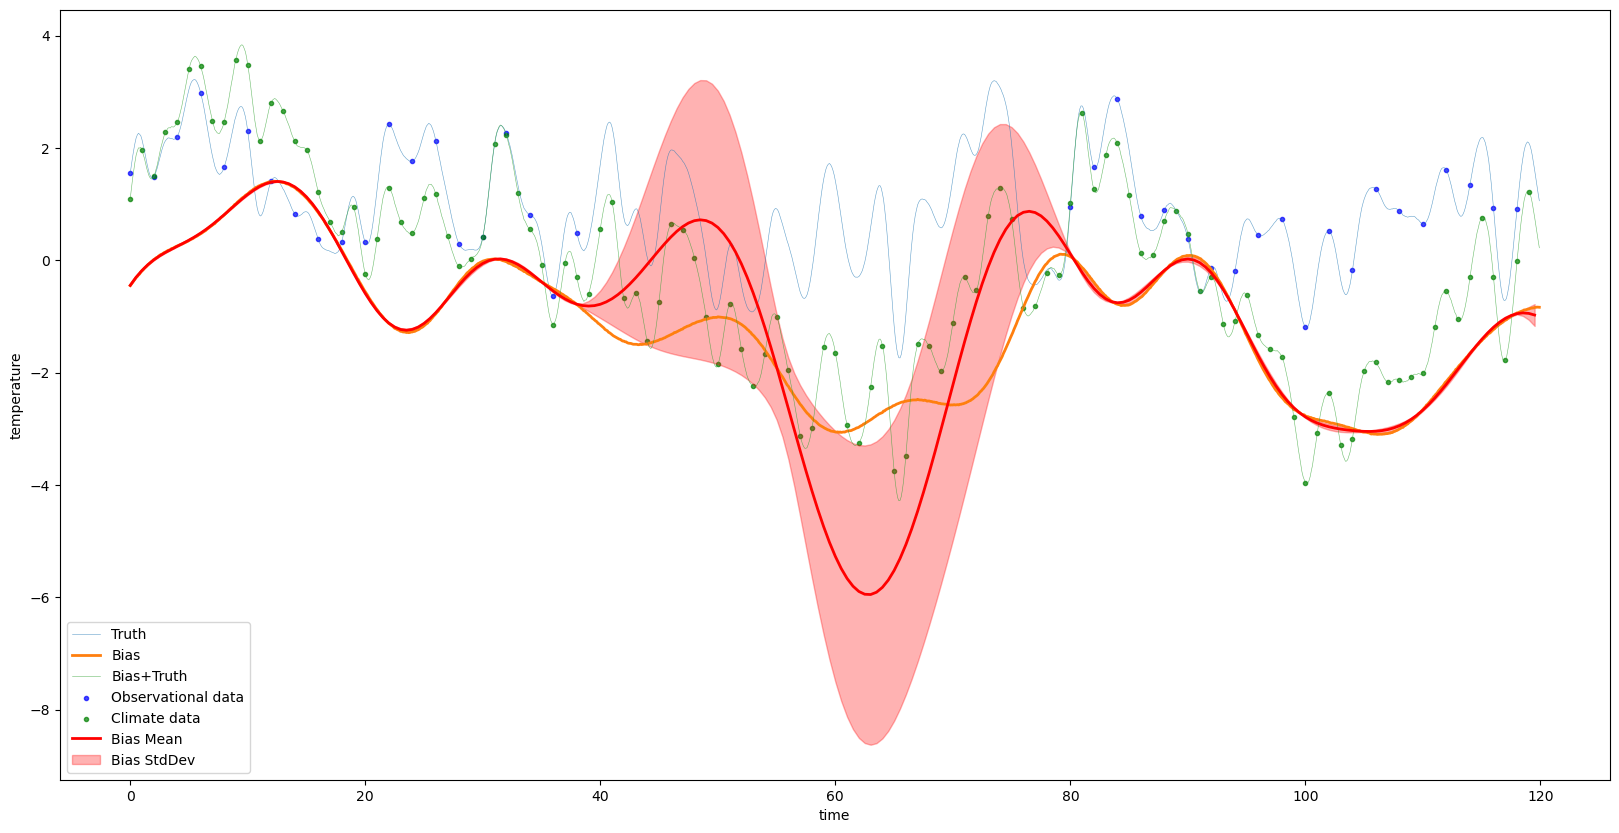

In [14]:
#Plotting Posterior Predictive for Bias
plt.figure(figsize=(20,10))

plt.plot(X,Y,label='Truth',alpha=0.7)
plt.plot(X,Y2,label='Bias',alpha=1,linewidth=2)
plt.plot(X,Y+Y2,label='Bias+Truth',alpha=0.7)

plt.scatter(ox,odata,color='b',label='Observational data',alpha=0.7)
plt.scatter(cx,cdata,color='g',label='Climate data',alpha=0.7)

bias_pred_mean = bias_realisations.mean(axis=0)
bias_pred_std = bias_realisations.std(axis=0)
plt.plot(nx,bias_pred_mean,label='Bias Mean',color='r',alpha=1.0,linewidth=2)
plt.fill_between(nx,bias_pred_mean+bias_pred_std,bias_pred_mean-bias_pred_std,label='Bias StdDev',color='r',alpha=0.3)

plt.xlabel('time')
plt.ylabel('temperature')
plt.legend()

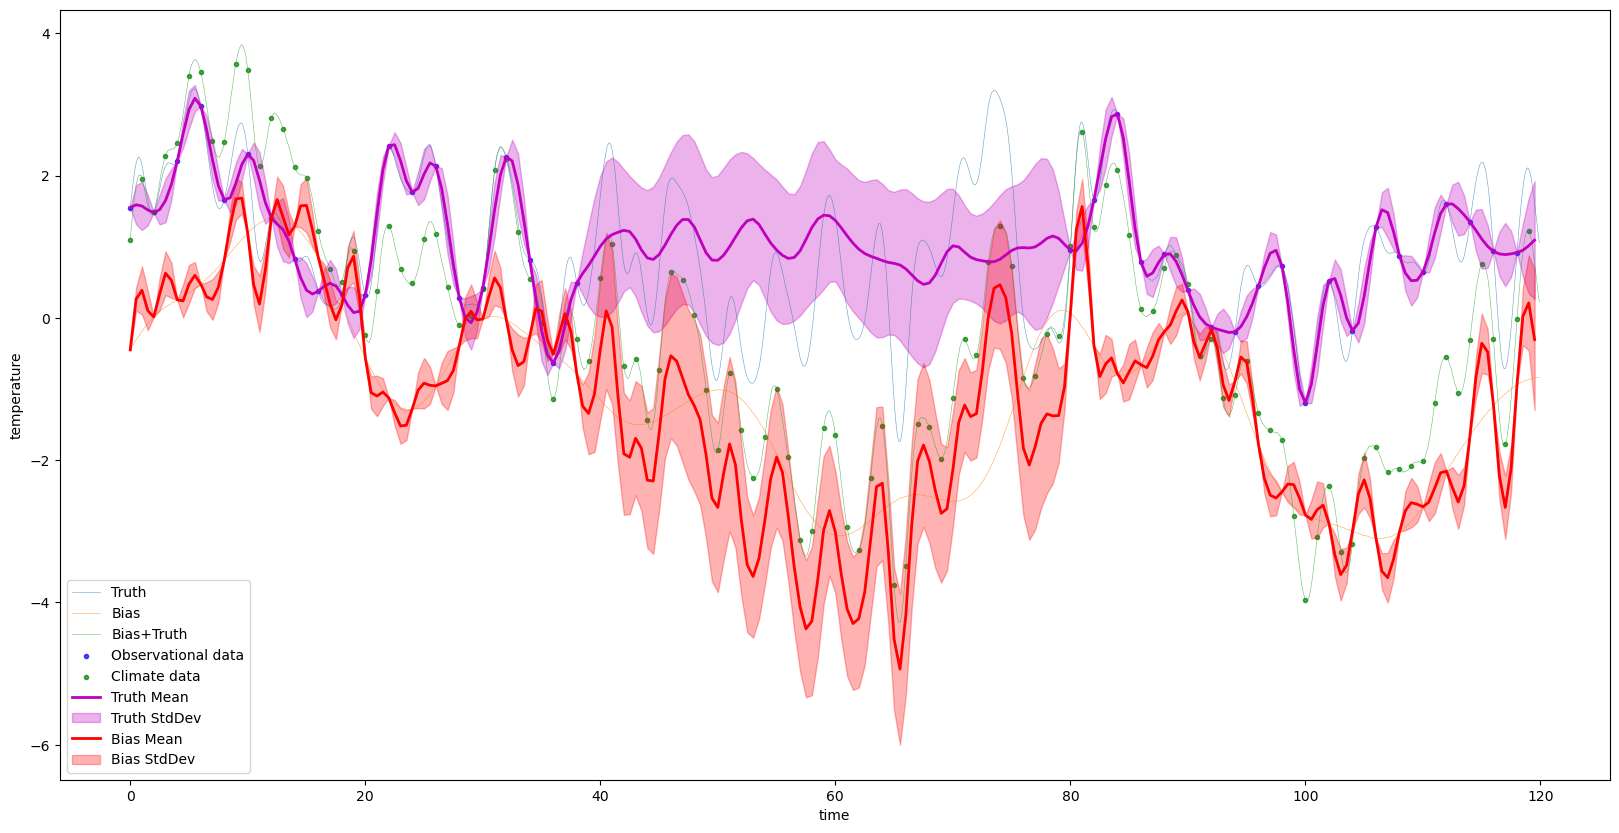

In [15]:
#Plotting Posterior Predictive for Single Process Model

plt.figure(figsize=(20,10))

plt.plot(X,Y,label='Truth',alpha=0.7)
plt.plot(X,Y2,label='Bias',alpha=0.7)
plt.plot(X,Y+Y2,label='Bias+Truth',alpha=0.7)

plt.scatter(ox,odata,color='b',label='Observational data',alpha=0.7)
plt.scatter(cx,cdata,color='g',label='Climate data',alpha=0.7)

sp_truth_pred_mean = sp_truth_realisations.mean(axis=0)
sp_truth_pred_std = sp_truth_realisations.std(axis=0)
plt.plot(nx,sp_truth_pred_mean,label='Truth Mean',color='m',alpha=1.0,linewidth=2)
plt.fill_between(nx,sp_truth_pred_mean+sp_truth_pred_std,sp_truth_pred_mean-sp_truth_pred_std,label='Truth StdDev',color='m',alpha=0.3)

sp_bias_pred_mean = (sp_climate_realisations-sp_truth_realisations).mean(axis=0)
sp_bias_pred_std = (sp_climate_realisations-sp_truth_realisations).std(axis=0)
plt.plot(nx,sp_bias_pred_mean,label='Bias Mean',color='r',alpha=1.0,linewidth=2)
plt.fill_between(nx,sp_bias_pred_mean+sp_bias_pred_std,sp_bias_pred_mean-sp_bias_pred_std,label='Bias StdDev',color='r',alpha=0.3)

plt.xlabel('time')
plt.ylabel('temperature')
plt.legend()